<a href="https://colab.research.google.com/github/lucasmoncada08/Face-Emotions-Classifier/blob/master/Happiness_Face_Scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating the Dataset from Google Images

In [1]:
# Downloading the previous PyTorch and torchvision version to silence warnings caused by fastai functions
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 23.7MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


## Search and Scroll

Google Images was used, whereas I used google search with the following three queries:
   
1.   happy person face
2.   sad person face
3.   angry person face

From these queries I ran some Javascript code in my Google Chrome using Cmd+Option+j and pasting the following code in the console.

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## Create Directory and Upload Urls File

In [109]:
from fastai.vision import *

In [112]:
folder = 'happy'
file = 'happy.csv'

In [114]:
folder = 'sad'
file = 'sad.csv'

In [116]:
folder = 'angry'
file = 'angry.csv'

This cell must be run after each of the six above categories individually

In [117]:
path = Path('data/facial_expressions')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [118]:
path.ls()

[PosixPath('data/facial_expressions/angry'),
 PosixPath('data/facial_expressions/happy'),
 PosixPath('data/facial_expressions/sad')]

At this point the downloaded csv file of the image links were uploaded to the colab data 

In [119]:
classes = [ 'happy', 'sad', 'angry']

In [120]:
file = 'happy.csv'
folder = 'happy'
dest = path/folder

In [123]:
file = 'sad.csv'
folder = 'sad'
dest = path/folder

In [125]:
file = 'angry.csv'
folder = 'angry'
dest = path/folder

This below cell must be run for each above category

In [126]:
download_images(path/folder/file, dest, max_pics=800)

## Exploring the Data

In [127]:
import cv2
from google.colab.patches import cv2_imshow

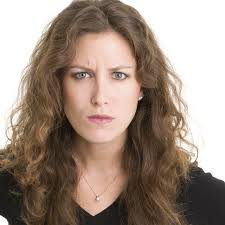

In [130]:
img = cv2.imread('/content/data/facial_expressions/angry/00000002.jpg')
cv2_imshow(img)

In [131]:
path = Path('/content/data/facial_expressions/')
for category in classes:
  print('number of', category, 'people:', len((path/category).ls()))

number of happy people: 481
number of sad people: 401
number of angry people: 321


In [132]:
# Verifying Images
for category in classes:
  print(category)
  verify_images(path/category, delete=True, max_size=500)

happy


sad


angry


00000000.jpg


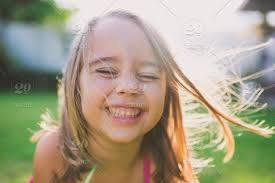

00000001.jpg


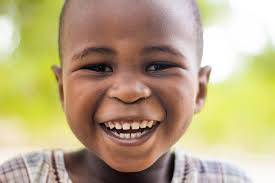

00000002.jpg


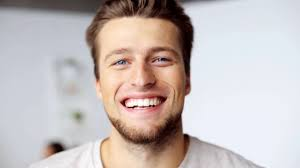

In [183]:
# Visualizing images to find some erroneously classified images and delete them manually
# I spent about an hour deleting cartoon like characters and misclassified examples

path = '/content/data/facial_expressions/happy'
start_index = 0
# works for up to 100 images
for i in range(start_index, start_index+3):
  i_pic = list('00000000')
  i_pic[6] = str(i//10)
  i_pic[7] = str(i%10)
  pic = "".join(i_pic)
  pic = pic + ".jpg"
  print(pic)
  img = cv2.imread(path + "/" + pic)
  cv2_imshow(img)

In [184]:
path = Path('/content/data/facial_expressions/')
for category in classes:
  print('number of', category, 'people:', len((path/category).ls()))

number of happy people: 221
number of sad people: 181
number of angry people: 237


In [185]:
# Create the dataset
np.random.seed(123)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.15,
                                  ds_tfms=get_transforms(), size=224, num_workers=4)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (539 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
angry,angry,angry,angry,angry
Path: /content/data/facial_expressions;

Valid: LabelList (94 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sad,sad,happy,sad,happy
Path: /content/data/facial_expressions;

Test: None

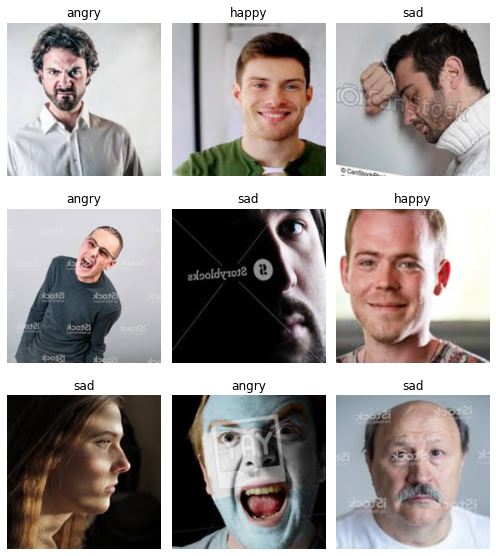

In [186]:
# Visualize a few examples
data.show_batch(rows=3, figsize=(7, 8))

In [187]:
print(data.c, data.classes)
print(len(data.train_ds), len(data.valid_ds))

3 ['angry', 'happy', 'sad']
539 94


## Training the Model

In [188]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [189]:
# First training with base layers frozen still
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.708839,1.805309,0.500000,00:15
1,1.506303,2.284964,0.606383,00:12
2,1.267245,1.409441,0.595745,00:11
3,1.069472,1.199902,0.617021,00:11
4,0.942676,1.179089,0.595745,00:12


In [190]:
learn.save('stage-1')

In [191]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


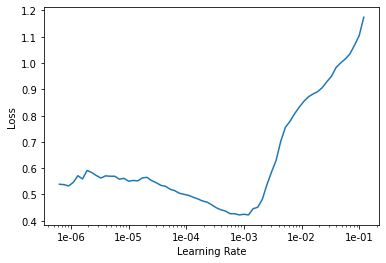

In [192]:
learn.lr_find()
learn.recorder.plot()

In [193]:
learn.fit_one_cycle(8, max_lr=slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.623288,1.134785,0.627660,00:14
1,0.543498,1.142905,0.627660,00:15
2,0.451099,1.135159,0.659574,00:15
3,0.382900,1.003525,0.648936,00:14
4,0.313214,0.993301,0.617021,00:15
5,0.268025,1.004832,0.670213,00:15
6,0.238742,0.990316,0.670213,00:15
7,0.210356,0.997492,0.670213,00:15


In [194]:
learn.save('stage-2')

In [195]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.125322,0.967199,0.691489,00:15
1,0.121675,1.058688,0.691489,00:14
2,0.101058,1.277793,0.670213,00:15
3,0.095759,1.178767,0.680851,00:14
4,0.085442,1.223706,0.659574,00:15
5,0.083731,1.135088,0.702128,00:14
6,0.085431,1.085563,0.712766,00:15
7,0.076040,1.088706,0.712766,00:14
8,0.068524,1.110852,0.723404,00:15
9,0.061171,1.106712,0.723404,00:14


In [199]:
learn.save('stage-3')

##Interpretation

In [196]:
interp = ClassificationInterpretation.from_learner(learn)

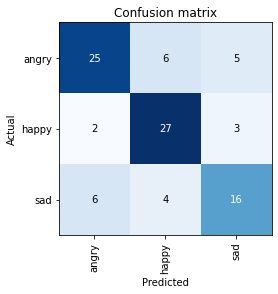

In [197]:
interp.plot_confusion_matrix()

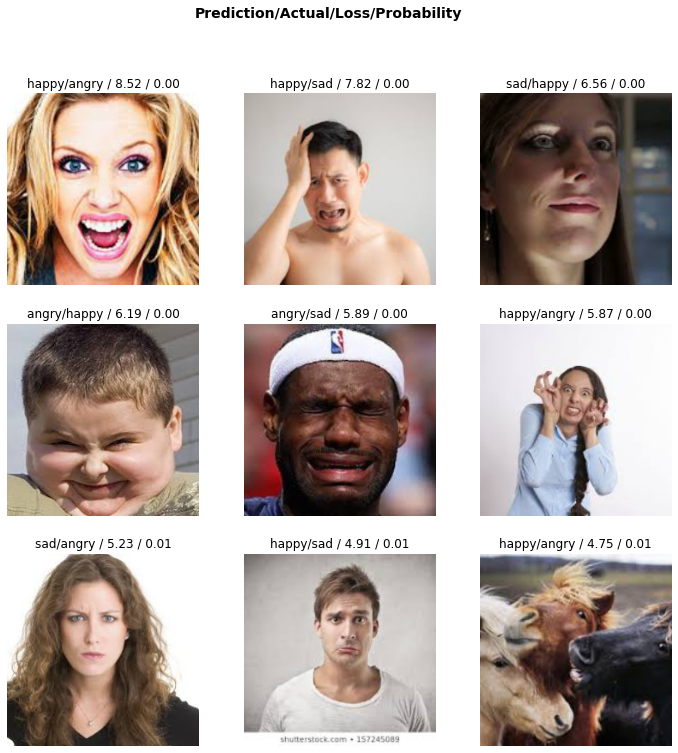

In [200]:
interp.plot_top_losses(9)

##Cleaning Up

In [201]:
from fastai.widgets import *

In [203]:
# Create a new database without the split
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [204]:
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)

learn_cln.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (633 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
angry,angry,angry,angry,angry
Path: /content/data/facial_expressions;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/data/facial_expressions;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [205]:
# Get top losses images
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [206]:
# Using fastai widget to delete / change class of the top losses examples if necessary
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [207]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [208]:
# Using fastai widget to remove duplicates
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

##Retraining a Model on the Cleaned Dataset

In [217]:
np.random.seed(42)

path = Path('/content/data/facial_expressions')
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.15, 
                               csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(),
                               num_workers=4,
                               size=224).normalize(imagenet_stats)

In [218]:
print(data.classes, data.c)
print(len(data.train_ds), len(data.valid_ds))

['angry', 'happy', 'sad'] 3
524 92


In [220]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [221]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.631277,0.961896,0.652174,00:15
1,1.503912,1.908057,0.565217,00:12
2,1.313072,1.513885,0.619565,00:12
3,1.144393,1.183612,0.673913,00:12
4,1.041067,1.127030,0.663043,00:12


In [ ]:
learn.save('stage-1')

In [222]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


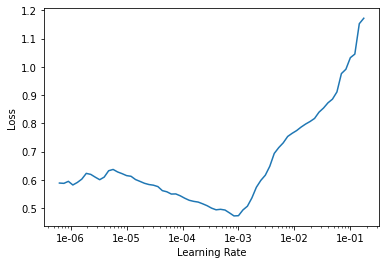

In [223]:
learn.lr_find()
learn.recorder.plot()

In [224]:
learn.fit_one_cycle(8, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.624838,1.107170,0.652174,00:15
1,0.593257,1.140362,0.652174,00:15
2,0.482589,0.898936,0.706522,00:14
3,0.409209,0.960424,0.728261,00:15
4,0.348902,0.890523,0.728261,00:15
5,0.294887,0.807593,0.750000,00:15
6,0.259862,0.752010,0.760870,00:15
7,0.223759,0.744538,0.771739,00:15


In [225]:
learn.save('stage-2')

In [226]:
learn.fit_one_cycle(20, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.092862,0.747612,0.760870,00:15
1,0.098431,0.740494,0.771739,00:15
2,0.077957,0.771271,0.771739,00:15
3,0.083030,0.736472,0.771739,00:15
4,0.082126,0.712397,0.804348,00:15
5,0.074425,0.751119,0.793478,00:15
6,0.075159,0.886831,0.760870,00:15
7,0.067693,0.999855,0.728261,00:15
8,0.064974,0.963283,0.739130,00:15
9,0.058446,1.072329,0.717391,00:14


Looks like it the accuracy is pretty much maxing out around 80%. However, I think that that is not bad considering I made the dataset from relatively low quality data directly from google images (and not much data as well). On the other hand, this does show that informative and quality data is very valuable.

##Intepreting the Updated Model

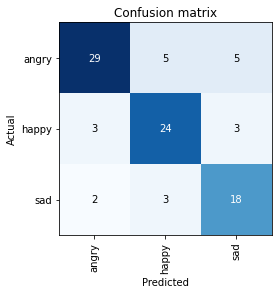

In [227]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Not bad results from looking at the confusion matrix. There does not seem to be any large misunderstood categories given that the misclassified examples are practically evenly split.

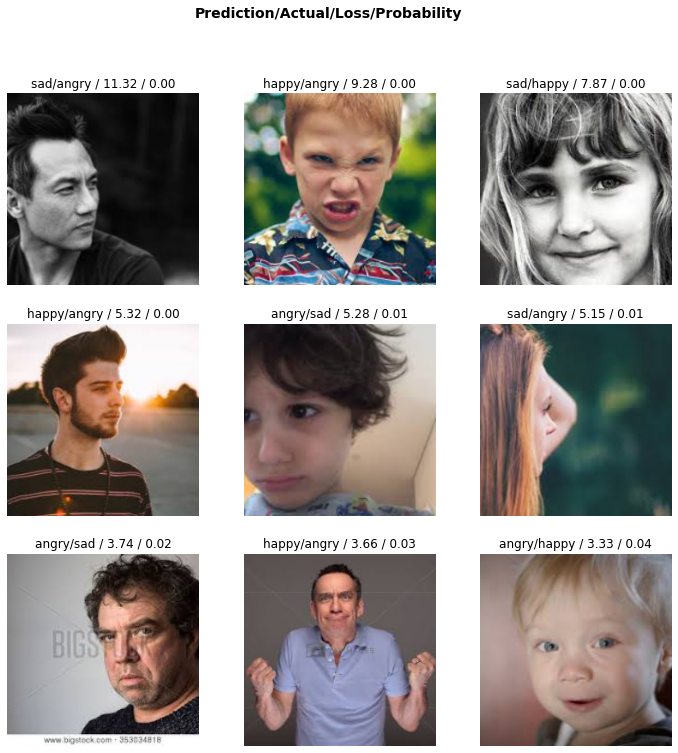

In [229]:
interp.plot_top_losses(9)

It can also be seen from these top losses that some of the mistakes are understandable. This makes me feel more comfortable about the techniques used. Furthermore I believe that if more time was spent on gathering data from other queries and sources, in addition to more data curation, that this approach would be much more successful.

I personally think this would have some interesting applications given it allows software to react to the emotions of a human. For example, imagine you are coming home and you are in a fantastic mood. Wouldn't it be awesome if your favourite upbeat song came on as you walked into your house to greet you. Or maybe you are having a upsetting day whereas your house light bulbs might change colours to reflect your sadness (this may not be desired, but just an idea).